# Self Study Project: #  
## Road Edge Detecting ##

#### Author: Zixan Wang ###
#### Email: ziw081@ucsd.edu ###
#### Class: CSE 152A ###

### Goal: Be able to simultaneously detect road edges while driving/walking ###

### The entire project will be divided into 3 sections. ###

#### 1. Be able to detect edges of a single image
#### 2. Be able to detect edges of a video
#### 3. Use GPU to accelerate the runtime speed. 

In [1]:
# Setup
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import convolve
from collections import defaultdict
from PIL import Image

## Section 1: ## 
### Descriptions: ###
Detect road edges through finding derivatives of the values in a grayed version of the input image. 

### Steps: ###
1. Convert an input image into a gray color image. 
2. Smoothe the gray image using convolution. 
3. Find the gradient of the image. 
4. Set threshold to ensure image correctly outputed an image with edges. 

In [2]:
def gaussian2d(filter_size, sig):
    """
    Creates 2D Gaussian kernel with side length `filter_size` and a sigma of `sig`.
    Source: https://stackoverflow.com/a/43346070
    """
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)


In [3]:
def smooth(image, sig):
    """ 
    Args:
        image: input image (h, w)
        
    Returns:
        smooth_image: smoothened version of the input image (h, w) 
    """
    
    smooth_image = np.zeros_like(image)
    
    smooth_image = convolve (image, gaussian2d(9, sig), mode='same')

#     smooth_kernal = np.array ([ [1,4,7,4,1], [4,16,26,16,4], [7,26,41,26,7], [1,4,7,4,1], [4,16,26,16,4]])
    
#     smooth_image = convolve (image, smooth_kernal, mode='same')
    
    return smooth_image


In [4]:
def gradient(image):
    """ 
    Args:
        image: input image (h, w)

    Returns:
        g_mag: gradient magnitude (h, w)
        g_theta: gradient direction (h, w)
    """
        
    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)
    

    part_x_kernal = np.array ([ [1,0,-1], [2,0,-2], [1,0,-1]])
    part_y_kernal = part_x_kernal.T
    
    g_x = convolve (image, part_x_kernal, mode='same')
    g_y = convolve (image, part_y_kernal, mode='same')
    
    g_mag = np.sqrt (g_x**2 + g_y**2)
    g_theta = np.arctan2 (g_y, g_x)

     
    
    return g_mag, g_theta

In [5]:
def edge_detect(image, sig):
    """Perform edge detection on the image."""
    smoothed = smooth(image, sig)
    g_mag, g_theta = gradient(smoothed)
    return smoothed, g_mag, g_theta

In [6]:
# Load image in grayscale
# image = io.imread('road_set1_1.jpg', as_gray=True)
image = io.imread('road_set1_2.png', as_gray=True)
smoothed, g_mag, g_theta = edge_detect(image, 5)

Original:


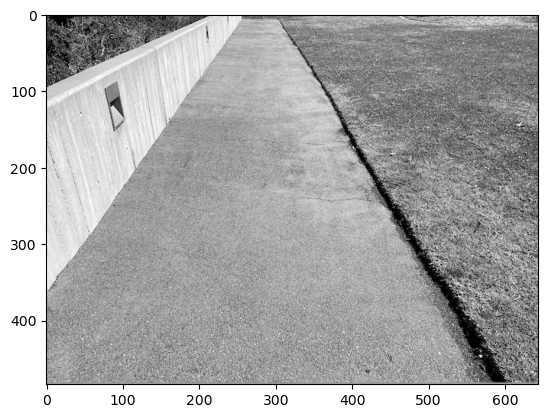

Smoothed:


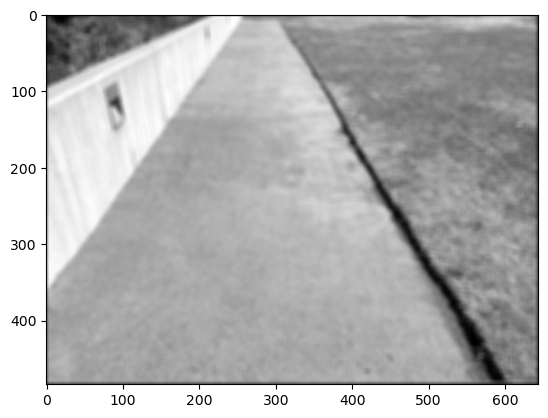

Gradient magnitude:


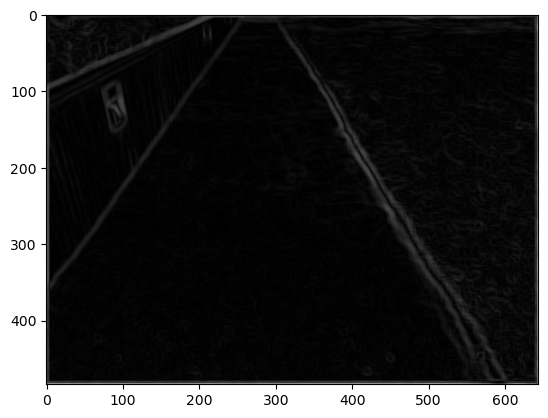

Gradient direction:


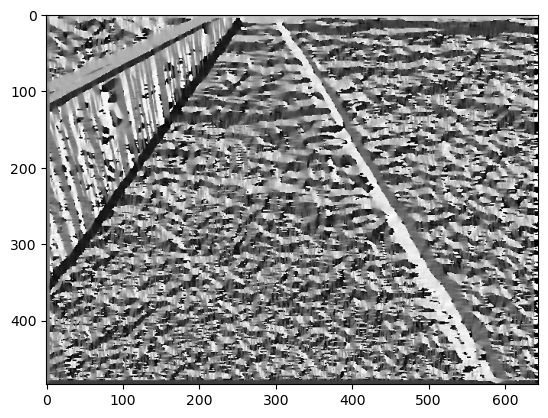

In [7]:
print('Original:')
plt.imshow(image, cmap='gray')
plt.show()

print('Smoothed:')
plt.imshow(smoothed, cmap='gray')
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag, cmap='gray')
plt.show()

print('Gradient direction:')
plt.imshow(g_theta, cmap='gray')
plt.show()

In [8]:
# print('Gradient magnitude:')
# plt.imshow(g_mag)
# plt.show()

# print('Gradient direction:')
# plt.imshow(g_theta)
# plt.show()

In [9]:
# print (g_mag.shape)
# print (np.mean (g_mag))
# g_mag_mean = np.mean (g_mag)
# print (sum (g_mag > 0.8))

In [10]:
def add_red_line (image_rgb, sig, threshold):
    """
    Given a 3 dimensional array, find its edges in gray color, then plot the edges
    in red to the given image
    
    Input: 3d image array
    
    output: 3d image array
    """
    smoothed = np.zeros_like (image_rgb)
    
    size = image_rgb.shape
    
    # Array copy
    for i in range (size[0]):
        for j in range (size[1]):
            for k in range (size[2]):
                smoothed [i,j,k] = image_rgb [i,j,k]
    
    # smoothing
    smoothed[:,:,0] = smooth(smoothed[:,:,0], sig)
    smoothed[:,:,1] = smooth(smoothed[:,:,1], sig)
    smoothed[:,:,2] = smooth(smoothed[:,:,2], sig)
    
    
    # Create a gray scale image from input rgb image
    image_gray = np.zeros_like (image_rgb[:,:,0])
    image_gray = 0.299*smoothed[:,:,0] + 0.587*smoothed[:,:,1] + 0.114*smoothed[:,:,2]
    
    # Get the mag and theta to find the edges
    img_mag, img_theta = gradient (image_gray)
    
    
    # add edges in red to the given image
    red_img = np.zeros_like (image_rgb)
    
    # Array copy
    for i in range (size[0]):
        for j in range (size[1]):
            for k in range (size[2]):
                red_img [i,j,k] = image_rgb [i,j,k]
    
    
    start0 = size[0]//100
    end0 = size[0] - size[0]//100
    
    start1 = size[1]//100
    end1 = size[1] - size[1]//100
    
    red_lines_loc = (g_mag[start0:end0,start1:end1] < (1-threshold))
    
    red_img[start0:end0,start1:end1,1] = red_img[start0:end0,start1:end1,1] * red_lines_loc
    red_img[start0:end0,start1:end1,2] = red_img[start0:end0,start1:end1,2] * red_lines_loc

    
    
    return red_img, smoothed, img_mag, img_theta

In [11]:
image_no_gray = io.imread('road_set1_2.png', as_gray=False)

red_img, image_no_gray_smoothed, img_mag, img_theta = add_red_line (image_no_gray, 20, 0.77)

print (sum(sum((image_no_gray == image_no_gray_smoothed) == 0)))

[303751 303947 303668      0]


(484, 644, 4)


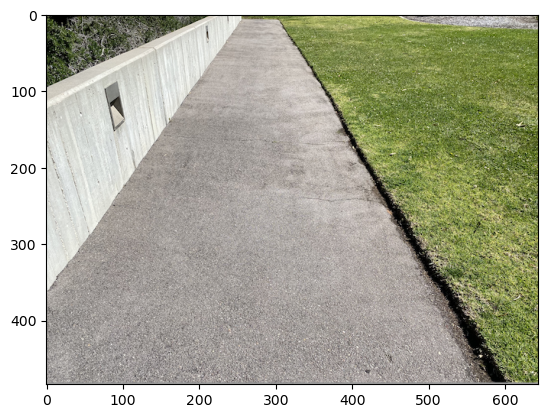

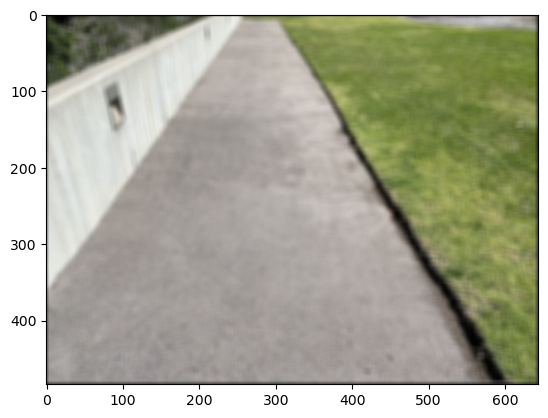

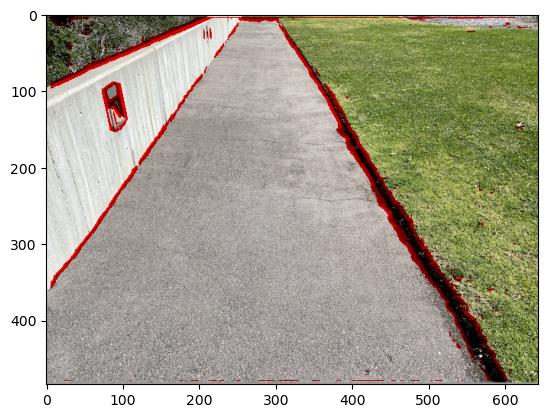

In [12]:
# image_no_gray = io.imread('road_set1_1.jpg', as_gray=False)
# image_no_gray = io.imread('road_set1_2.png', as_gray=False)
# image_no_gray_dup = io.imread('road_set1_2.png', as_gray=False)
# print (type (image_no_gray))

print (image_no_gray.shape)
plt.imshow (image_no_gray)
plt.show()

plt.imshow (image_no_gray_smoothed)
plt.show()

# plt.imshow (img_mag)
# plt.show()

# plt.imshow (img_theta)
# plt.show()

plt.imshow (red_img)
plt.show()


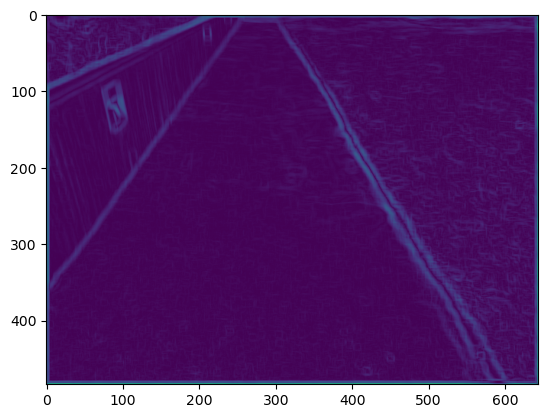

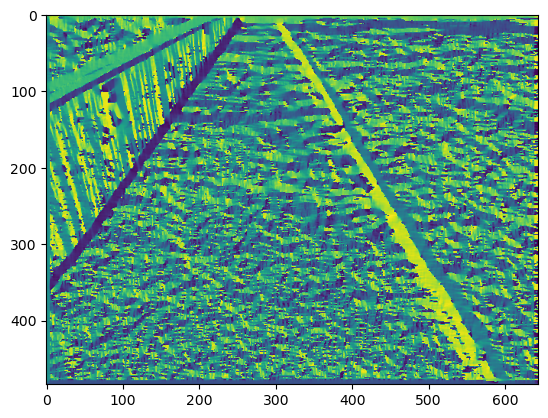

In [13]:
plt.imshow (img_mag)
plt.show()

plt.imshow (img_theta)
plt.show()

In [14]:
# img_theta[320:325,480:485]=100
# img_theta[320:325,520:525]=100
# img_theta[350:355,480:485]=100
# img_theta[350:355,520:525]=100

# plt.imshow (img_theta)
# plt.show()

# print (img_theta[320:350, 480:520])
print (image.shape)

(484, 644)


In [24]:
def point_direction (image, mag, threshold):
    
    # --------------------------------
    # ---- Initialization ----
    # --------------------------------
    
    width  = mag.shape[1]
    height = mag.shape[0]
    
    size = 100
    
    width_ex = int (width - (width // size)*size)
    y_start = int (width_ex//2)
    
    height_ex = int (height - (height // size)*size)
    x_start = int (height_ex//2)
    
    gridy = int ((height - y_start)//size)
    gridx = int ((width  - x_start)//size)
    
#     print (y_start,x_start)
#     print (gridy, gridx)
    
    gridy_reduced = gridy-2
    gridx_reduced = gridx-2
    
    grid = np.zeros ([gridy,gridx])
    reduced = np.zeros ([gridy_reduced,gridx_reduced])
    
    
    # --------------------------------
    # --Divide input image into grids-
    # --------------------------------
    for y in range (y_start, height-size, size):
        for x in range (x_start, width-size, size):
            if (np.sum (mag [y:y+size,x:x+size]) > threshold):
                grid [int(y//size),int(x//size)] = 1
            
    # --------------------------------
    # Get ride of the outer edge, assign to grid reduce
    # --------------------------------
    for y in range (1,gridy-1,1):
        for x in range (1,gridx-1,1):
            reduced[y-1,x-1] = grid[y,x]
     
    
    # --------------------------------------
    # ---- Finding road center position ----
    # --------------------------------------
    listy = []
    listx = []
    
    for y in range (gridy_reduced):
        for x in range (gridx_reduced):
            if (reduced[y,x] == 0):
                listy.append (y)
                listx.append (x)
                
    medy = int (np.median (listy))
    medx = int (np.median (listx))
    
    print (medy,medx)
    
    
    # ----------------------------------
    # ---- setting arrow parameters ----
    # ----------------------------------
    arrowY = y_start + size*(1+medx)
    arrowX = x_start + size*(1+medx)
    
    arrBodyWid = 20
    arrBodyHei = 100
    
    arrHeadWid = 40
    arrHeadHei = 40
    
    arrWid = 40
    arrHei = 140
    
    arr = np.ones ([arrBodyHei+arrHeadHei,arrHeadWid])
    
    # Draw arrow body
    for y in range (40,arr.shape[0],1):
        for x in range (int (arrBodyWid/2),int(arr.shape[1]-arrBodyWid/2),1):
            arr [y,x] = 0
            
#     # Draw arrow head-left
    for x in range (0,int (arr.shape[1]/2),1):
        for y in range (arrHeadHei,arrHeadHei-x,-1):
            arr [y,x] = 0
            
    # Draw arrow head-right
    for x in range (20,40,1):
        for y in range (x,arrHeadHei,1):
#             print (y,x)
            arr [y,x] = 0
            
    
    # ----------------------------------
    # ---- draw arrow on the image  ----
    # ----------------------------------
    
    arr_img = np.zeros_like (image)
    
    imgShape = image.shape
    
    # Array copy
    for i in range (imgShape[0]):
        for j in range (imgShape[1]):
            for k in range (imgShape[2]):
                arr_img [i,j,k] = image [i,j,k]
                
    arr_img [arrowY:arrowY+arrHei, arrowX:arrowX+arrWid,1] = \
                            arr_img [arrowY:arrowY+arrHei, arrowX:arrowX+arrWid,1] * arr
    arr_img [arrowY:arrowY+arrHei, arrowX:arrowX+arrWid,2] = \
                            arr_img [arrowY:arrowY+arrHei, arrowX:arrowX+arrWid,2] * arr
            
    return grid, reduced, arr_img

In [27]:
grid,gridR,arrImage = point_direction (red_img, img_mag, 100000)

1 1


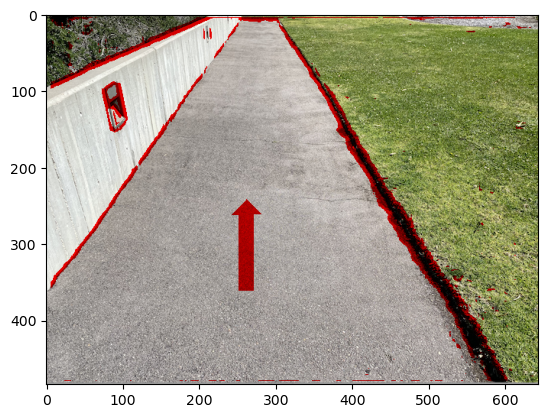

In [28]:
plt.imshow (arrImage)
plt.show()